# Experimental data analysis on foil open area
## Brian Larsen, ISR-1
## Data provided by Phil Fernandes, ISR-1 2016-9-14

The setup is a foil in its holder mounted to a foil holder meant to bock incident ions. The foil has a ~0.6mm hole in it to provide a baseline. The goal is to use the relative intensity of the witness hole to determine the intensity of holes in the foil.

A quick summary:
* Foil is placed 0.66” from front of MCP surface
* Beam is rastered to cover full foil and “witness” aperture
* Beam is 1.0 keV Ar+, slightly underfocused
* Accumulate data for set period of time (either 60s or 180s, identified in spreadsheet)
* Total_cts is the # of counts through the foil and the witness aperture
* Witness_cts is the # of counts in the witness aperture only
* Foil_cts = total_cts – witness_cts
* Open area OA = (foil_cts/witness_cts) * (witness_area/foil_area)

In [18]:
%matplotlib inline
#%matplotlib notebook
%load_ext version_information
%load_ext autoreload


In [19]:
import itertools
from pprint import pprint
from operator import getitem

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import spacepy.plot as spp
import pymc3 as mc3
import tqdm

from MCA_file_viewer_v001 import GetMCAfile

%version_information matplotlib, numpy, pymc3

Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 5.3.0
OS Darwin 15.6.0 x86_64 i386 64bit
matplotlib 2.0.0
numpy 1.12.1
pymc3 3.0
Wed Apr 19 16:57:19 2017 MDT

In [2]:
def plot_box(x, y, c='r', lw=0.6, ax=None):
    if ax is None:
        plt.plot((xind[0], xind[0]), (yind[0], yind[1]), lw=lw, c=c)
        plt.plot((xind[1], xind[1]), (yind[0], yind[1]), lw=lw, c=c)
        plt.plot((xind[0], xind[1]), (yind[0], yind[0]), lw=lw, c=c)
        plt.plot((xind[0], xind[1]), (yind[1], yind[1]), lw=lw, c=c)
    else:
        ax.plot((xind[0], xind[0]), (yind[0], yind[1]), lw=lw, c=c)
        ax.plot((xind[1], xind[1]), (yind[0], yind[1]), lw=lw, c=c)
        ax.plot((xind[0], xind[1]), (yind[0], yind[0]), lw=lw, c=c)
        ax.plot((xind[0], xind[1]), (yind[1], yind[1]), lw=lw, c=c)
        

In [3]:
ZZ, XX, YY = GetMCAfile('16090203.mca')
# It is believed as of 2016-09-19 that the MCA records 2 counts for each count. 
#    This means all data are even and all the data can be divided by 2 to give the
#    right number of counts. Per emails Larsen-Fernandes 2016-09-17
#    These data are integres and care muct be taken to assure that /2 does not
#    lead to number that are not representable in float
ZZ = ZZ.astype(float)
ZZ /= 2
XX = XX.astype(np.uint16) # as they all should be integers anyway


data size: 1024x1024


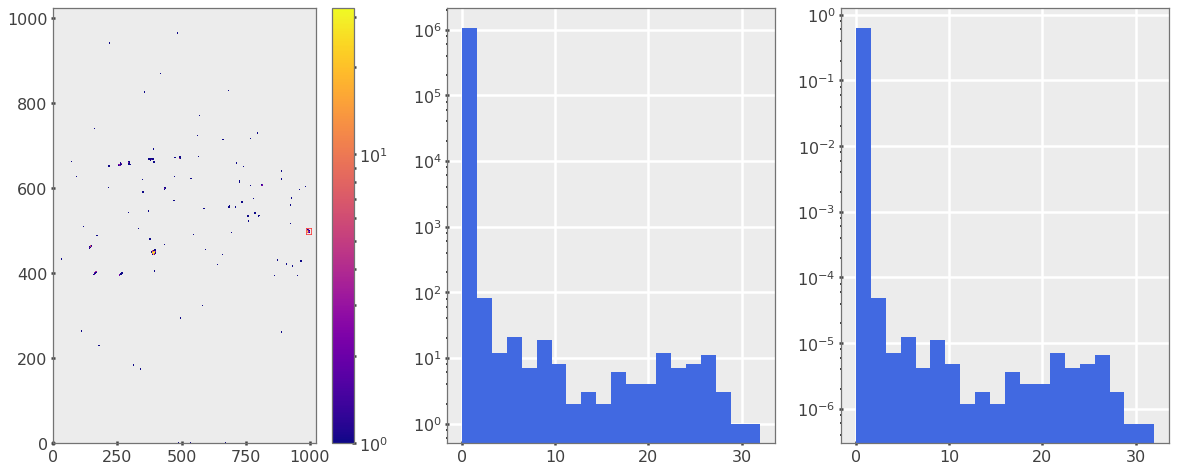

In [4]:
xind = (986, 1003)
yind = (492, 506)

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

pc = ax1.pcolormesh(XX, YY, ZZ, norm=LogNorm())
plt.colorbar(pc, ax=ax1)
plot_box(xind, yind, ax=ax1)

ax2.hist(ZZ.flatten(), 20)
ax2.set_yscale('log')

ax3.hist(ZZ.flatten(), 20, normed=True)
ax3.set_yscale('log')

## Do some calculations to try and match Phil's analysis

Phil's data:

File name	Witness cts	Total cts	Foil cts	Open area

16090203	658	4570	3912	0.00102

In [5]:
total_cnts = ZZ.sum()
print('Total counts:{0}  -- Phil got {1} -- remember /2'.format(total_cnts, 4570/2)) # remember we did a /2

Total counts:2285.0  -- Phil got 2285.0 -- remember /2


In [6]:
# Is the whitness hole at x=1000, y=500?
XX.shape, YY.shape, ZZ.shape

((1024,), (1024,), (1024, 1024))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   2.   2.   2.   2.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   1.   7.   9.   9.   8.   3.   3.   0.   1.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   3.   8.  18.  20.  12.   9.   6.   1.   0.   1.   0.
    0.   0.   0.]
 [  0.   0.   0.   2.  10.  23.  28.  16.   8.   6.   3.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   2.   9.  22.  17.  12.   8.   5.   1.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   0.   3.   7.   9.   4.   2.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [  0.   0

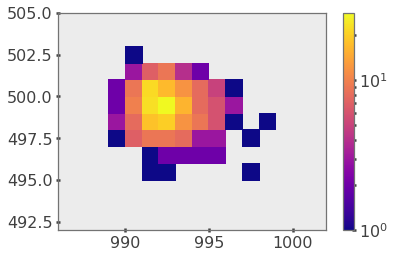

In [7]:

print(ZZ[yind[0]:yind[1], xind[0]:xind[1]])
plt.figure()
plt.pcolormesh(XX[xind[0]:xind[1]], YY[yind[0]:yind[1]], ZZ[yind[0]:yind[1], xind[0]:xind[1]] , norm=LogNorm())
plt.colorbar()

witness_counts = ZZ[yind[0]:yind[1], xind[0]:xind[1]].sum()

print('Witness counts: {0}, Phil got {1}/2={2}'.format(witness_counts, 658, 658/2))
wit_pixels = 46
print('There {0} pixels in the witness peak'.format(wit_pixels))

total_counts = ZZ.sum()
print("There are a total of {0} counts".format(total_counts))


## Can we get a noise estimate? 
1) Try all pixels with a value where a neighbor does not. This assumes that real holes are large enough to have a point spread function and therefore cannot be in a single pixel.

In [10]:
def neighbor_inds(x, y, xlim=(0,1023), ylim=(0,1023), center=False, mask=False):
    """
    given an x and y index return the 8 neighbor indices
    
    if center also return the center index
    if mask return a boolean mask over the whole 2d array
    """
    xi = np.clip([x + v for v in [-1, 0, 1]], xlim[0], xlim[1])
    yi = np.clip([y + v for v in [-1, 0, 1]], ylim[0], ylim[1])
    ans = [(i, j) for i, j in itertools.product(xi, yi)]
    if not center:
        ans.remove((x,y))
    if mask:
        out = np.zeros((np.diff(xlim)+1, np.diff(ylim)+1), dtype=np.bool)
        for c in ans:
            out[c] = True
    else:
        out = ans
    return np.asarray(out)

print(neighbor_inds(2,2))
# print(neighbor_inds(2,2, mask=True))
# print(ZZ[neighbor_inds(500, 992, mask=True)])

    

[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]


In [11]:
def get_alone_pixels(dat):
    """
    loop over all the data and store the value of all lone pixels
    """
    ans = []
    for index, x in tqdm.tqdm_notebook(np.ndenumerate(dat)):
        if (np.sum([ZZ[i, j] for i, j in neighbor_inds(index[0], index[1])]) == 0) and x != 0:
            ans.append((index, x))
    return ans
# print((neighbor_inds(5, 4)))
alone = get_alone_pixels(ZZ)
pprint(alone)
# ZZ[neighbor_inds(5, 4)[0]].shape
# print((neighbor_inds(5, 4))[0])
# print(ZZ[(neighbor_inds(5, 4))[0]].shape)
# ZZ[4,3]


[((174, 339), 1.0),
 ((184, 313), 1.0),
 ((229, 178), 1.0),
 ((261, 889), 1.0),
 ((264, 111), 1.0),
 ((294, 495), 1.0),
 ((323, 581), 1.0),
 ((394, 863), 1.0),
 ((394, 951), 1.0),
 ((405, 394), 1.0),
 ((417, 932), 1.0),
 ((420, 641), 1.0),
 ((421, 907), 1.0),
 ((428, 965), 1.0),
 ((431, 874), 1.0),
 ((433, 31), 1.0),
 ((444, 659), 1.0),
 ((455, 593), 1.0),
 ((467, 434), 1.0),
 ((480, 377), 1.0),
 ((489, 170), 1.0),
 ((491, 545), 1.0),
 ((495, 693), 1.0),
 ((495, 997), 1.0),
 ((505, 333), 1.0),
 ((509, 117), 1.0),
 ((517, 925), 1.0),
 ((522, 759), 1.0),
 ((534, 758), 1.0),
 ((541, 786), 1.0),
 ((543, 292), 1.0),
 ((546, 370), 1.0),
 ((552, 587), 1.0),
 ((555, 684), 1.0),
 ((555, 709), 1.0),
 ((560, 923), 1.0),
 ((570, 470), 1.0),
 ((575, 779), 1.0),
 ((577, 928), 1.0),
 ((591, 349), 1.0),
 ((596, 958), 1.0),
 ((598, 434), 1.0),
 ((601, 214), 1.0),
 ((603, 981), 1.0),
 ((606, 769), 1.0),
 ((613, 724), 1.0),
 ((613, 726), 1.0),
 ((620, 347), 1.0),
 ((621, 890), 1.0),
 ((622, 536), 1.0),


In [12]:
ZZ[(965, 485)]

1.0

In [13]:
print(neighbor_inds(4,3)[0])
print(ZZ[neighbor_inds(4,3)[0]])
print(ZZ[3,2])

ni = neighbor_inds(4,3)[0]
print(ZZ[ni[0], ni[1]])

[3 2]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0.0
0.0


In [14]:
(ZZ % 2).any() # not all even any longer

True

### Noise estimates
Not we assume that all lone counts are noise that can be considered random and uniform over the MCP. 
This then provides a number of counts per MCA pixel that we can use. 

In [15]:
n_noise = np.sum([v[1] for v in alone])
n_pixels = 1024*1024
noise_pixel = n_noise/n_pixels
print("There were a total of {0} random counts over {1} pixels, {2} cts/pixel".format(n_noise, n_pixels, noise_pixel))

There were a total of 71.0 random counts over 1048576 pixels, 6.771087646484375e-05 cts/pixel


Maybe we should consider just part of the MCP, lets get the min,max X and min,max Y where there are counts and just use that area. This will increase the cts/pixel.

In [16]:
minx_tmp = ZZ.sum(axis=0)
minx_tmp.shape
print(minx_tmp)

miny_tmp = ZZ.sum(axis=1)
miny_tmp.shape
print(miny_tmp)



[  4.   0.   0. ...,   0.   0.  31.]
[ 3.  0.  0. ...,  0.  0.  5.]


Looks to go all the way to all sides in X-Y.

## Work to total open area calculations
Now we can model the total open area of the foil given the noise estimate per pixel and the pixels that are a part of the witness sample and the total area.

We model the observed background as Poisson with center at the real background:

$obsnbkg \sim Pois(nbkg)$

We model the observed witness sample, $obswit$, as Poisson with center of background per pixel times number of pixels in peak plus the number of real counts:

$obswit \sim Pois(nbkg/C + witc)$, $C = \frac{A_w}{A_t}$

This then leaves the number of counts in open areas of the system (excluding witness) as a Poisson with center of background per pixel times number of pixels in the system (less witness) plus the real number of counts.

$obsopen \sim Pois(nbkg/D + realc)$, $D=\frac{A_t - A_w}{A_t}$

Then then the open area is given by the ratio number of counts, $realc$, over an unknown area, $A_o$, as related to witness counts, $witc$, to the witness area, $A_w$, which is assumed perfect as as 0.6mm hole.

$\frac{A_o}{realc}=\frac{A_w}{witc} => A_o = \frac{A_w}{witc}realc $


In [17]:
Aw = np.pi*(0.2/2)**2 # mm**2
Af = 182.75 # mm**2  this is the area of the foil
W_F_ratio = Aw/Af

print(Aw, Af, W_F_ratio)

C = wit_pixels/n_pixels
D = (n_pixels-wit_pixels)/n_pixels
print('C', C, 'D', D)



0.031415926535897934 182.75 0.00017190657475183547
C 4.38690185546875e-05 D 0.9999561309814453


In [26]:
with mc3.Model() as model:
    nbkg = mc3.Uniform('nbkg', 1, n_noise*5) # just 1 to some large number
    obsnbkg = mc3.Poisson('obsnbkg', nbkg, observed=n_noise)

    witc = mc3.Uniform('witc', 0, witness_counts*5) # just 0 to some large number
    obswit = mc3.Poisson('obswit', nbkg*C + witc, observed=witness_counts)

    realc = mc3.Uniform('realc', 0, total_counts*5) # just 0 to some large number
    obsopen = mc3.Poisson('obsopen', nbkg*D + realc, observed=total_counts-witness_counts)

#     @mc.deterministic(plot=True)
#     def open_area(realc=realc, witc=witc):
#         return realc*Aw/witc/Af
    
    
    open_area = mc3.Deterministic('open_area', realc*Aw/witc/Af)
    start = mc3.find_MAP()
    trace = mc3.sample(20000, start=start)
    


Optimization terminated successfully.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -22.666: 100%|██████████| 200000/200000 [00:21<00:00, 9231.38it/s] 
Finished [100%]: Average ELBO = -22.673
100%|██████████| 20000/20000 [00:16<00:00, 1246.65it/s]

         Current function value: 17.228087
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14



nbkg:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  71.995           8.302            0.059            [55.676, 88.287]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  56.510         66.320         71.667         77.409         89.141


witc:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  329.995          18.088           0.126            [294.853, 365.593]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  295.670        317.606        329.602        342.028        366.604


realc:

  Mean             SD               MC Error         95% HPD interval
  ------------------

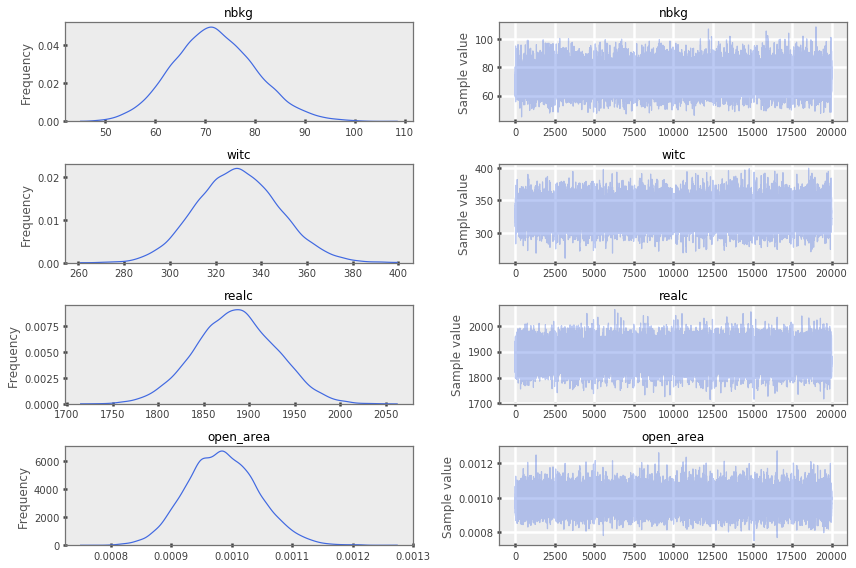

In [27]:
mc3.traceplot(trace);
mc3.summary(trace)



In [28]:
print("Foil 1 \n")

witc_mean = np.mean(trace['witc'])
witc_std = np.std(trace['witc'])

print("Found witness counts of {0} turn into {1} +/- {2}  ({3:.2f}%)\n".format(witness_counts, witc_mean, witc_std, witc_std/witc_mean*100))

realc_mean = np.mean(trace['realc'])
realc_std = np.std(trace['realc'])

print("Found non-witness counts of {0} turn into {1} +/- {2}  ({3:.2f}%)\n".format(total_counts-witness_counts, realc_mean, realc_std, realc_std/realc_mean*100))

nbkg_mean = np.mean(trace['nbkg'])
nbkg_std = np.std(trace['nbkg'])

print("Found noise counts of {0} turn into {1} +/- {2}  ({3:.2f}%)\n".format(0, nbkg_mean, nbkg_std, nbkg_std/nbkg_mean*100))

OA_median = np.median(trace['open_area'])
OA_mean = np.mean(trace['open_area'])
OA_std = np.std(trace['open_area'])
print("The open area fraction is {0:.6f} +/- {1:.6f}   ({2:.2f}%) at the 1 stddev level from 1 measurement\n".format(OA_mean, OA_std,OA_std/OA_mean*100 ))
print("Phil got {0} for 1 measurement\n".format(0.00139))
print("The ratio Brian/Phil is: {0:.6f} or {1:.6f}".format(OA_mean/0.00139, 0.00139/OA_mean))


Foil 1 

Found witness counts of 329.0 turn into 329.99454090174 +/- 18.088088184843983  (5.48%)

Found non-witness counts of 1956.0 turn into 1884.7771412765883 +/- 44.489472703718114  (2.36%)

Found noise counts of 0 turn into 71.99487857925634 +/- 8.302365335606543  (11.53%)

The open area fraction is 0.000985 +/- 0.000059   (5.97%) at the 1 stddev level from 1 measurement

Phil got 0.00139 for 1 measurement

The ratio Brian/Phil is: 0.708492 or 1.411449


## Run again allowing some uncertainity on witness and foil areas

In [35]:

_Aw = np.pi*(0.2/2)**2 # mm**2
_Af = 182.75 # mm**2  this is the area of the foil
print(_Aw, _Af)


with mc3.Model() as model:
    nbkg = mc3.Uniform('nbkg', 1, n_noise*5) # just 1 to some large number
    obsnbkg = mc3.Poisson('obsnbkg', nbkg, observed=n_noise)
    Aw = mc3.Normal('Aw', _Aw, sd=_Aw*0.2) # 20%
    Af = mc3.Normal('Af', _Af, sd=_Af*0.1)  # 10%

    C = wit_pixels/n_pixels
    D = (n_pixels-wit_pixels)/n_pixels


    witc = mc3.Uniform('witc', 0, witness_counts*5) # just 0 to some large number
    obswit = mc3.Poisson('obswit', nbkg*C + witc, observed=witness_counts)

    realc = mc3.Uniform('realc', 0, total_counts*5) # just 0 to some large number
    obsopen = mc3.Poisson('obsopen', nbkg*D + realc, observed=total_counts-witness_counts)

#     @mc.deterministic(plot=True)
#     def open_area(realc=realc, witc=witc):
#         return realc*Aw/witc/Af
    
    
    open_area = mc3.Deterministic('open_area', realc*Aw/witc/Af)
    start = mc3.find_MAP()
    trace = mc3.sample(20000, start=start)
    

    

0.031415926535897934 182.75
Optimization terminated successfully.
         Current function value: 16.901620

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -22.678: 100%|██████████| 200000/200000 [00:23<00:00, 8624.64it/s]
Finished [100%]: Average ELBO = -22.699
100%|██████████| 20000/20000 [00:19<00:00, 1009.14it/s]


         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14



Aw:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.031            0.006            0.000            [0.019, 0.044]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.019          0.027          0.031          0.036          0.043


Af:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  182.716          18.092           0.126            [148.458, 219.079]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  147.075        170.355        182.673        195.228        218.008


nbkg:

  Mean             SD               MC Error         95% HPD interval
  --------------------------

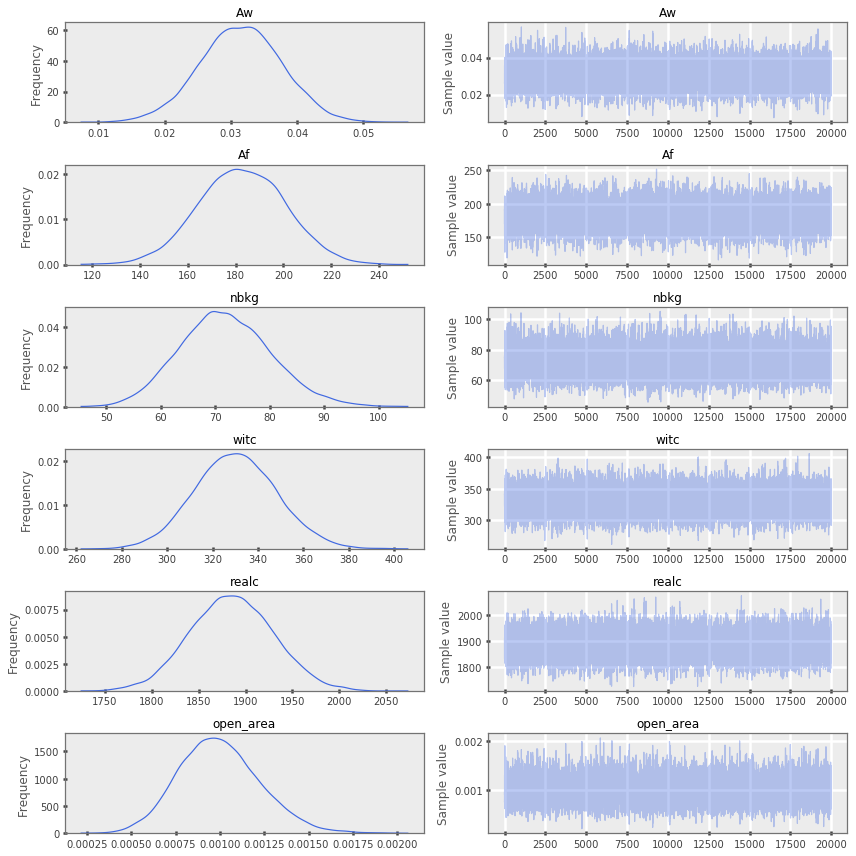

In [36]:
mc3.traceplot(trace);
mc3.summary(trace)



In [37]:
print("Foil 1 \n")

witc_mean = np.mean(trace['witc'])
witc_std = np.std(trace['witc'])
print("Found witness counts of {0} turn into {1} +/- {2}  ({3:.2f}%)\n".format(witness_counts, witc_mean, witc_std, witc_std/witc_mean*100))

realc_mean = np.mean(trace['realc'])
realc_std = np.std(trace['realc'])

print("Found non-witness counts of {0} turn into {1} +/- {2}  ({3:.2f}%)\n".format(total_counts-witness_counts, realc_mean, realc_std, realc_std/realc_mean*100))

nbkg_mean = np.mean(trace['nbkg'])
nbkg_std = np.std(trace['nbkg'])

print("Found noise counts of {0} turn into {1} +/- {2}  ({3:.2f}%)\n".format(0, nbkg_mean, nbkg_std, nbkg_std/nbkg_mean*100))

OA_median = np.median(trace['open_area'])
OA_mean = np.mean(trace['open_area'])
OA_std = np.std(trace['open_area'])
print("The open area fraction is {0:.6f} +/- {1:.6f}   ({2:.2f}%) at the 1 stddev level from 1 measurement\n".format(OA_mean, OA_std,OA_std/OA_mean*100 ))
print("Phil got {0} for 1 measurement\n".format(0.00139))
print("The ratio Brian/Phil is: {0:.6f} or {1:.6f}".format(OA_mean/0.00139, 0.00139/OA_mean))


Foil 1 

Found witness counts of 329.0 turn into 329.9586089978238 +/- 18.04755201451918  (5.47%)

Found non-witness counts of 1956.0 turn into 1884.8967460054657 +/- 44.59569224048363  (2.37%)

Found noise counts of 0 turn into 71.96291130713553 +/- 8.33204628747655  (11.58%)

The open area fraction is 0.000995 +/- 0.000230   (23.12%) at the 1 stddev level from 1 measurement

Phil got 0.00139 for 1 measurement

The ratio Brian/Phil is: 0.716026 or 1.396597
